In [1]:
import pandas as pd
import numpy as np

np.float_ = np.float64

from prophet import Prophet
import requests
from datetime import datetime, timedelta
import duckdb as db

m = Prophet()
conn = db.connect("file.db")
conn.sql("""
    -- y is the amount charged for the transaction
    -- ds is the time the transaction took place

    CREATE SEQUENCE seq_id START 1;
    CREATE TABLE contract_call (y INTEGER, ds DATETIME UNIQUE)
""")

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Get data

end_time = datetime.now()
print(end_time.timestamp())
start_time = (end_time - timedelta(seconds=3600.0)).timestamp()
print(start_time)

transaction_types = ["CONTRACTCALL"]

from typing import Union
from pprint import pprint

def get_data(start_time: float | int, limit: int, transaction_type: str, order: Union["asc", "desc"]):
    url = f"https://testnet.mirrornode.hedera.com/api/v1/transactions?limit={limit}&order={order}&timestamp=gte%3A{start_time}&transactiontype={transaction_type}"
    data = requests.get(url).json()
    transactions = data["transactions"]
    new_transactions: list[dict | None] = []
    for transaction in transactions:
        new_data = {}
        if not transaction["scheduled"] and transaction["result"] == "SUCCESS":
            _, seconds, nanoseconds = transaction["transaction_id"].split("-")
            new_data["charged_tx_fee"] = transaction["charged_tx_fee"]
            new_data["time_tx_occured"] = datetime.fromtimestamp(float(f"{seconds}.{nanoseconds}")).isoformat()

            new_transactions.append(new_data)
    return new_transactions


transactions: list[dict | None] = get_data(start_time, 100, transaction_types[0], "asc")
pprint(transactions)

1723995186.371474
1723991586.371474
[{'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:37:34.407830'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:39:10.629529'},
 {'charged_tx_fee': 18840000, 'time_tx_occured': '2024-08-18T14:41:47.132385'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:42:38.341037'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:45:09.524219'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:45:34.333568'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:46:39.851021'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:46:44.568648'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:47:57.889111'},
 {'charged_tx_fee': 9420000, 'time_tx_occured': '2024-08-18T14:49:51.193571'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:50:02.909686'},
 {'charged_tx_fee': 125600000, 'time_tx_occured': '2024-08-18T14:50:59.01924

In [6]:
try:
    for transaction in transactions:
        conn.sql(f"""
            INSERT INTO contract_call VALUES ('{transaction["charged_tx_fee"]}', '{transaction["time_tx_occured"]}')
        """)
except db.ConstraintException:
    pass

In [7]:
conn.sql("""
    SELECT * FROM contract_call
""").show()

┌───────────┬────────────────────────────┐
│     y     │             ds             │
│   int32   │         timestamp          │
├───────────┼────────────────────────────┤
│ 125600000 │ 2024-08-18 14:37:34.40783  │
│ 125600000 │ 2024-08-18 14:39:10.629529 │
│  18840000 │ 2024-08-18 14:41:47.132385 │
│ 125600000 │ 2024-08-18 14:42:38.341037 │
│ 125600000 │ 2024-08-18 14:45:09.524219 │
│ 125600000 │ 2024-08-18 14:45:34.333568 │
│ 125600000 │ 2024-08-18 14:46:39.851021 │
│ 125600000 │ 2024-08-18 14:46:44.568648 │
│ 125600000 │ 2024-08-18 14:47:57.889111 │
│   9420000 │ 2024-08-18 14:49:51.193571 │
│      ·    │             ·              │
│      ·    │             ·              │
│      ·    │             ·              │
│ 124000000 │ 2024-08-18 15:09:55.19099  │
│  12400000 │ 2024-08-18 15:10:20.688261 │
│ 124000000 │ 2024-08-18 15:10:49.656414 │
│ 124000000 │ 2024-08-18 15:21:27.872082 │
│ 124000000 │ 2024-08-18 15:21:32.991542 │
│ 124000000 │ 2024-08-18 15:21:35.829148 │
│ 124000000

In [8]:
df = conn.sql("""
    SELECT ds, y FROM contract_call
""").to_df()
df.tail()

,ds,y
31,2024-08-18 15:21:35.829148,124000000
32,2024-08-18 15:23:52.910748,124000000
33,2024-08-18 15:25:37.612321,12400000
34,2024-08-18 15:28:24.684052,124000000
35,2024-08-18 15:29:29.685623,124000000


In [9]:
m.fit(df)
future = m.make_future_dataframe(periods=1, freq="H")

15:33:27 - cmdstanpy - INFO - Chain [1] start processing
15:33:27 - cmdstanpy - INFO - Chain [1] done processing
/home/codespace/.python/current/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [23]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
32,2024-08-18 15:23:52.910748,1.004359e+08,4.735468e+07,1.530039e+08,1.004359e+08,1.004359e+08,0.0,0.0,0.0,0.0,0.0,0.0,1.004359e+08
33,2024-08-18 15:25:37.612321,9.999584e+07,4.761442e+07,1.513547e+08,9.999584e+07,9.999584e+07,0.0,0.0,0.0,0.0,0.0,0.0,9.999584e+07
34,2024-08-18 15:28:24.684052,9.929361e+07,4.504023e+07,1.479842e+08,9.929361e+07,9.929361e+07,0.0,0.0,0.0,0.0,0.0,0.0,9.929361e+07
35,2024-08-18 15:29:29.685623,9.902040e+07,4.411039e+07,1.521775e+08,9.902040e+07,9.902040e+07,0.0,0.0,0.0,0.0,0.0,0.0,9.902040e+07
36,2024-08-18 16:29:29.685623,8.388913e+07,3.201752e+07,1.371097e+08,8.388913e+07,8.388913e+07,0.0,0.0,0.0,0.0,0.0,0.0,8.388913e+07


/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


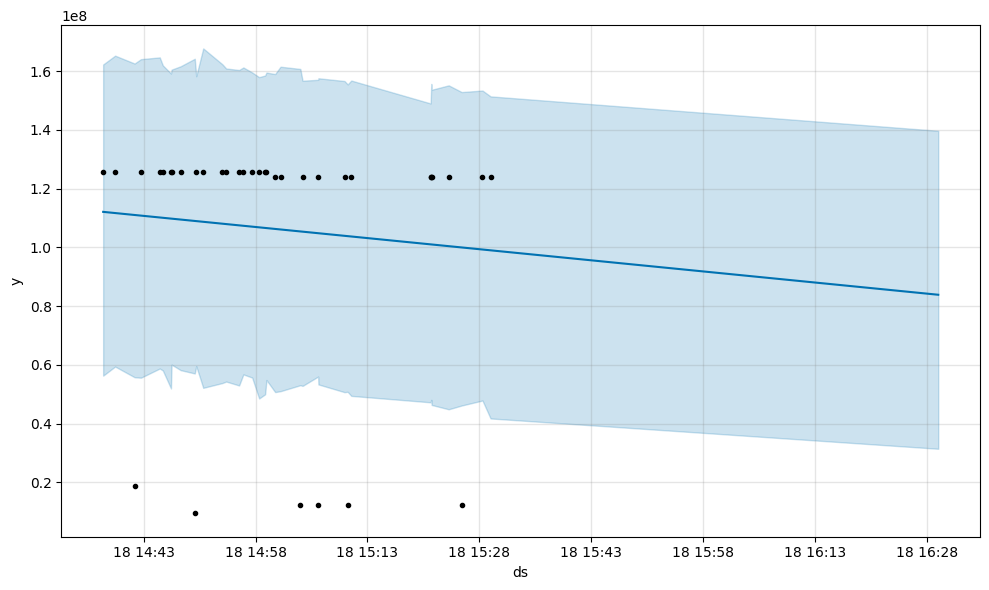

In [11]:
fig1 = m.plot(forecast)

/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


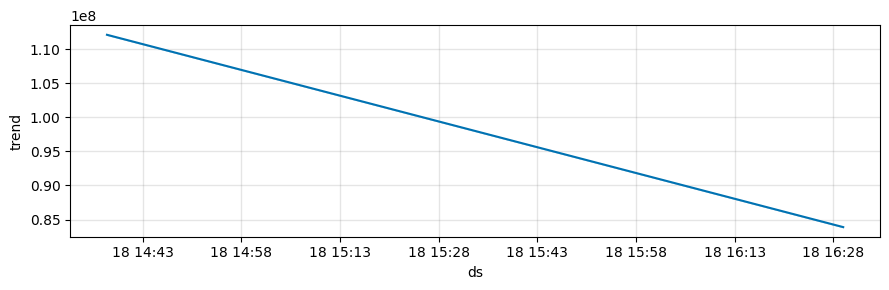

In [12]:
fig2 = m.plot_components(forecast)

In [24]:
forecast[["ds", "yhat"]].tail()

,ds,yhat
32,2024-08-18 15:23:52.910748,1.004359e+08
33,2024-08-18 15:25:37.612321,9.999584e+07
34,2024-08-18 15:28:24.684052,9.929361e+07
35,2024-08-18 15:29:29.685623,9.902040e+07
36,2024-08-18 16:29:29.685623,8.388913e+07


In [26]:
forecast_dict = forecast[["ds", "yhat"]].to_dict()
pprint(forecast_dict)

{'ds': {0: Timestamp('2024-08-18 14:37:34.407830'),
        1: Timestamp('2024-08-18 14:39:10.629529'),
        2: Timestamp('2024-08-18 14:41:47.132385'),
        3: Timestamp('2024-08-18 14:42:38.341037'),
        4: Timestamp('2024-08-18 14:45:09.524219'),
        5: Timestamp('2024-08-18 14:45:34.333568'),
        6: Timestamp('2024-08-18 14:46:39.851021'),
        7: Timestamp('2024-08-18 14:46:44.568648'),
        8: Timestamp('2024-08-18 14:47:57.889111'),
        9: Timestamp('2024-08-18 14:49:51.193571'),
        10: Timestamp('2024-08-18 14:50:02.909686'),
        11: Timestamp('2024-08-18 14:50:59.019243'),
        12: Timestamp('2024-08-18 14:53:32.701785'),
        13: Timestamp('2024-08-18 14:54:03.849637'),
        14: Timestamp('2024-08-18 14:55:47.752150'),
        15: Timestamp('2024-08-18 14:56:21.833189'),
        16: Timestamp('2024-08-18 14:57:32.391839'),
        17: Timestamp('2024-08-18 14:58:28.706549'),
        18: Timestamp('2024-08-18 14:59:16.889971'),
   

In [31]:
new_data = {"x": [], "y": []}

ds = forecast_dict["ds"]
y = forecast_dict["yhat"]
for value in ds.values():
    new_data["x"].append(str(value))
for value in y.values():
    new_data["y"].append(value)

id = "".join(["predict-", str(datetime.fromisoformat(new_data["x"][0]).timestamp()), "-", str(datetime.fromisoformat(new_data["x"][-1]).timestamp())])
new_data["id"] = id

pprint(new_data)

{'id': 'predict-1723991854.40783-1723998569.685623',
 'x': ['2024-08-18 14:37:34.407830',
       '2024-08-18 14:39:10.629529',
       '2024-08-18 14:41:47.132385',
       '2024-08-18 14:42:38.341037',
       '2024-08-18 14:45:09.524219',
       '2024-08-18 14:45:34.333568',
       '2024-08-18 14:46:39.851021',
       '2024-08-18 14:46:44.568648',
       '2024-08-18 14:47:57.889111',
       '2024-08-18 14:49:51.193571',
       '2024-08-18 14:50:02.909686',
       '2024-08-18 14:50:59.019243',
       '2024-08-18 14:53:32.701785',
       '2024-08-18 14:54:03.849637',
       '2024-08-18 14:55:47.752150',
       '2024-08-18 14:56:21.833189',
       '2024-08-18 14:57:32.391839',
       '2024-08-18 14:58:28.706549',
       '2024-08-18 14:59:16.889971',
       '2024-08-18 14:59:27.474893',
       '2024-08-18 15:00:37.525722',
       '2024-08-18 15:01:20.603627',
       '2024-08-18 15:04:00.022748',
       '2024-08-18 15:04:18.103520',
       '2024-08-18 15:06:23.462534',
       '2024-08-18 15: